### This notebook includes the experiments for cross validation.

- Standing agent is P1, we are learning P2 (P2 is human player).

- Some frames will be removed, there are frames that;
    - Both players standing.
    - Consecutive ones(If frame's action is same with previous frame, it will be removed).
    - If we are(P2) in RECOV frame(Since we don't make RECOV frames ourselves).

### Importing libraries

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import TensorBoard
from time import time
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# For using core package that located in the two upper folder.
import sys
sys.path.append('../../')

from core.json_importer import parse_json_file, parse_all_files
from core.filters import remove_both_standing_frames, remove_same_consecutive_actions, remove_recov_frames
from core.actions import one_hot_encode, decode
from core.preproccessing import Normalizer
from core.helpers import write_file

Using TensorFlow backend.


In [2]:
# Open files
training_data = parse_all_files("data/train")
testing_data = parse_all_files("data/test")

### Pre process data

- In the pre process phase, we remove P2's datas from training set in order to crate labels. Labels are just actions of P2.

- We make actions one-hot encoding. 

- One-hot encoding for inputs and labels are not same. For example, Dash action in the input may have encoding [0,1] while Dash action in the label have encoding [0, 0, 1, 0].

- Integer values normalized. (P1-HP, P2-HP, P1-X, P1-Y, P2-X, P2-Y)

- After pre-process we just have <font color='red'>[P1-Action, P1-HP, P2-HP, P1-X, P1-Y, P2-X, P2-Y] -> P2-Action</font>

#### Remove unneeded frames

In [3]:
# Apply filters for training data
tr_deleted = training_data.filter(remove_both_standing_frames)
tr_deleted += training_data.filter(remove_recov_frames)
tr_deleted += training_data.filter(remove_same_consecutive_actions)

# Apply filters for training data
te_deleted = testing_data.filter(remove_both_standing_frames)
te_deleted += testing_data.filter(remove_recov_frames)
te_deleted += testing_data.filter(remove_same_consecutive_actions)

print('There are {} train data.({} deleted.)'.format(len(training_data), tr_deleted))
print('There are {} test data.({} deleted.)'.format(len(testing_data), te_deleted))

There are 11428 train data.(485372 deleted.)
There are 1221 test data.(52779 deleted.)


#### Encoding and normalization

In [4]:
def normalize_and_save(data, file_name):
    p1_hp_normalizer = Normalizer()
    p1_normalized_hp = p1_hp_normalizer.normalize(data)
    p1_hp_normalizer.save("out_files/" + file_name)
    return p1_normalized_hp

def process_data(game_data_obj):
    ## Pre process data
    processed_data = []

    # Create one hot encoding for actions (For input and labels)
    p1_one_hot_encoded_actions = one_hot_encode(game_data_obj.get_column("P1-action"))
    labels = one_hot_encode(game_data_obj.get_column("P2-action"))

    # Normalize uncategorized features
    p1_normalized_hp = normalize_and_save(game_data_obj.get_column("P1-hp"), "p1_hp_norm.save")
    p2_normalized_hp = normalize_and_save(game_data_obj.get_column("P2-hp"), "p2_hp_norm.save")
    normalized_x_distance = normalize_and_save([frame["P1-x"] - frame["P2-x"] for frame in game_data_obj], "x_norm.save")
    normalized_y_distance = normalize_and_save([frame["P1-y"] - frame["P2-y"] for frame in game_data_obj], "y_norm.save")
    normalized_xp1_distance = normalize_and_save([frame["P1-x"] for frame in game_data_obj], "xp1_norm.save")
    normalized_xp2_distance = normalize_and_save([frame["P2-x"] for frame in game_data_obj], "xp2_norm.save")
    normalized_yp1_distance = normalize_and_save([frame["P1-y"] for frame in game_data_obj], "yp1_norm.save")
    normalized_yp2_distance = normalize_and_save([frame["P2-y"] for frame in game_data_obj], "yp2_norm.save")

    for index in range(len(game_data_obj)):    
        processed_row = []
        processed_row.extend(p1_one_hot_encoded_actions[index])
        processed_row.extend(p1_normalized_hp[index]) 
        processed_row.extend(p2_normalized_hp[index])
        processed_row.extend(normalized_x_distance[index])
        processed_row.extend(normalized_y_distance[index])
        processed_row.extend(normalized_xp1_distance[index])
        processed_row.extend(normalized_xp2_distance[index])
        processed_row.extend(normalized_yp1_distance[index])
        processed_row.extend(normalized_yp2_distance[index])
        processed_data.append(processed_row)
    processed_data = np.array(processed_data)
    labels = np.array(labels)
    
    return processed_data, labels
    
tr_data, tr_labels = process_data(training_data)
te_data, te_labels = process_data(testing_data)

### Example data

In [5]:
EXAMPLE_ROW = 10

print("There are %d frames in dataset." % len(tr_data))
print("After pre processing the shape of our dataset is %s" % str(tr_data.shape))
print("\nOne example in index %d." % EXAMPLE_ROW)

row = tr_data[EXAMPLE_ROW]
print("\tProcessed Frame:" )
print("\t\tP1 Action(one-hot):\t%s" % row[0: 55])
print("\t\tP1 Hp(norm.):\t\t%s" % row[55])
print("\t\tP2 Hp(norm.):\t\t%s" % row[56])
print("\t\tX Dist(norm.):\t\t%s" % row[57])
print("\t\tY Dist(norm.):\t\t%s" % row[58])
print("\t\tLabel:\t\t\t%s" % tr_labels[EXAMPLE_ROW])

There are 11428 frames in dataset.
After pre processing the shape of our dataset is (11428, 63)

One example in index 10.
	Processed Frame:
		P1 Action(one-hot):	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
		P1 Hp(norm.):		0.01594896331738437
		P2 Hp(norm.):		0.010683760683760684
		X Dist(norm.):		0.04660452729693742
		Y Dist(norm.):		0.4398034398034398
		Label:			[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Neural Network Design

Our neural network has two hidden layers in this test. They has 12 and 8 neurons respectively.

In [6]:
# Constants
INPUT_LAYER_SIZE = tr_data.shape[1]
OUTPUT_LAYER_SIZE = tr_labels.shape[1]

In [7]:
model = Sequential()
model.add(Dense(100, input_dim=INPUT_LAYER_SIZE, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(OUTPUT_LAYER_SIZE, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
# Logging for tensorboard
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [9]:
history = model.fit(tr_data, tr_labels, epochs=500, validation_split=0.2,
                    shuffle=True, batch_size=10, callbacks=[tensorboard])

Train on 9142 samples, validate on 2286 samples
Epoch 1/500
9142/9142 [==============================] - 2s 239us/step - loss: 0.1001 - acc: 0.9750 - val_loss: 0.0597 - val_acc: 0.9823
Epoch 2/500
9142/9142 [==============================] - 2s 206us/step - loss: 0.0590 - acc: 0.9825 - val_loss: 0.0553 - val_acc: 0.9828
Epoch 3/500
9142/9142 [==============================] - 2s 205us/step - loss: 0.0558 - acc: 0.9831 - val_loss: 0.0534 - val_acc: 0.9833
Epoch 4/500
9142/9142 [==============================] - 2s 196us/step - loss: 0.0541 - acc: 0.9832 - val_loss: 0.0521 - val_acc: 0.9837
Epoch 5/500
9142/9142 [==============================] - 2s 199us/step - loss: 0.0529 - acc: 0.9834 - val_loss: 0.0515 - val_acc: 0.9837
Epoch 6/500
9142/9142 [==============================] - 2s 210us/step - loss: 0.0522 - acc: 0.9835 - val_loss: 0.0509 - val_acc: 0.9838
Epoch 7/500
9142/9142 [==============================] - 2s 201us/step - loss: 0.0515 - acc: 0.9837 - val_loss: 0.0504 - val_acc: 

9142/9142 [==============================] - 2s 194us/step - loss: 0.0412 - acc: 0.9858 - val_loss: 0.0415 - val_acc: 0.9857
Epoch 61/500
9142/9142 [==============================] - 2s 194us/step - loss: 0.0411 - acc: 0.9857 - val_loss: 0.0412 - val_acc: 0.9857
Epoch 62/500
9142/9142 [==============================] - 2s 195us/step - loss: 0.0410 - acc: 0.9858 - val_loss: 0.0411 - val_acc: 0.9858
Epoch 63/500
9142/9142 [==============================] - 2s 191us/step - loss: 0.0410 - acc: 0.9858 - val_loss: 0.0410 - val_acc: 0.9858
Epoch 64/500
9142/9142 [==============================] - 2s 192us/step - loss: 0.0407 - acc: 0.9858 - val_loss: 0.0409 - val_acc: 0.9857
Epoch 65/500
9142/9142 [==============================] - 2s 195us/step - loss: 0.0407 - acc: 0.9858 - val_loss: 0.0408 - val_acc: 0.9857
Epoch 66/500
9142/9142 [==============================] - 2s 191us/step - loss: 0.0406 - acc: 0.9860 - val_loss: 0.0407 - val_acc: 0.9859
Epoch 67/500
9142/9142 [=======================

9142/9142 [==============================] - 2s 206us/step - loss: 0.0383 - acc: 0.9864 - val_loss: 0.0389 - val_acc: 0.9863
Epoch 120/500
9142/9142 [==============================] - 2s 212us/step - loss: 0.0383 - acc: 0.9864 - val_loss: 0.0391 - val_acc: 0.9862
Epoch 121/500
9142/9142 [==============================] - 2s 188us/step - loss: 0.0382 - acc: 0.9864 - val_loss: 0.0390 - val_acc: 0.9862
Epoch 122/500
9142/9142 [==============================] - 2s 190us/step - loss: 0.0383 - acc: 0.9864 - val_loss: 0.0391 - val_acc: 0.9863
Epoch 123/500
9142/9142 [==============================] - 2s 192us/step - loss: 0.0382 - acc: 0.9863 - val_loss: 0.0390 - val_acc: 0.9863
Epoch 124/500
9142/9142 [==============================] - 2s 193us/step - loss: 0.0382 - acc: 0.9865 - val_loss: 0.0390 - val_acc: 0.9863
Epoch 125/500
9142/9142 [==============================] - 2s 244us/step - loss: 0.0380 - acc: 0.9864 - val_loss: 0.0391 - val_acc: 0.9861
Epoch 126/500
9142/9142 [================

9142/9142 [==============================] - 2s 190us/step - loss: 0.0371 - acc: 0.9866 - val_loss: 0.0386 - val_acc: 0.9865
Epoch 179/500
9142/9142 [==============================] - 2s 191us/step - loss: 0.0370 - acc: 0.9867 - val_loss: 0.0388 - val_acc: 0.9863: 0.036
Epoch 180/500
9142/9142 [==============================] - 2s 226us/step - loss: 0.0369 - acc: 0.9867 - val_loss: 0.0385 - val_acc: 0.9865
Epoch 181/500
9142/9142 [==============================] - 2s 235us/step - loss: 0.0369 - acc: 0.9868 - val_loss: 0.0387 - val_acc: 0.9864
Epoch 182/500
9142/9142 [==============================] - 2s 194us/step - loss: 0.0371 - acc: 0.9866 - val_loss: 0.0385 - val_acc: 0.9864
Epoch 183/500
9142/9142 [==============================] - 2s 226us/step - loss: 0.0370 - acc: 0.9867 - val_loss: 0.0384 - val_acc: 0.9864
Epoch 184/500
9142/9142 [==============================] - 2s 221us/step - loss: 0.0370 - acc: 0.9866 - val_loss: 0.0384 - val_acc: 0.9865
Epoch 185/500
9142/9142 [=========

Epoch 237/500
9142/9142 [==============================] - 2s 193us/step - loss: 0.0362 - acc: 0.9868 - val_loss: 0.0384 - val_acc: 0.9864
Epoch 238/500
9142/9142 [==============================] - 2s 190us/step - loss: 0.0363 - acc: 0.9868 - val_loss: 0.0381 - val_acc: 0.9864
Epoch 239/500
9142/9142 [==============================] - 2s 191us/step - loss: 0.0363 - acc: 0.9867 - val_loss: 0.0382 - val_acc: 0.9866
Epoch 240/500
9142/9142 [==============================] - 2s 190us/step - loss: 0.0363 - acc: 0.9868 - val_loss: 0.0384 - val_acc: 0.9864
Epoch 241/500
9142/9142 [==============================] - 2s 189us/step - loss: 0.0361 - acc: 0.9869 - val_loss: 0.0381 - val_acc: 0.9865
Epoch 242/500
9142/9142 [==============================] - 2s 191us/step - loss: 0.0363 - acc: 0.9868 - val_loss: 0.0381 - val_acc: 0.9867
Epoch 243/500
9142/9142 [==============================] - 2s 191us/step - loss: 0.0361 - acc: 0.9869 - val_loss: 0.0382 - val_acc: 0.9865
Epoch 244/500
9142/9142 [==

Epoch 296/500
9142/9142 [==============================] - 2s 190us/step - loss: 0.0358 - acc: 0.9869 - val_loss: 0.0381 - val_acc: 0.9865
Epoch 297/500
9142/9142 [==============================] - 2s 190us/step - loss: 0.0356 - acc: 0.9871 - val_loss: 0.0383 - val_acc: 0.9869
Epoch 298/500
9142/9142 [==============================] - 2s 194us/step - loss: 0.0356 - acc: 0.9869 - val_loss: 0.0384 - val_acc: 0.9867
Epoch 299/500
9142/9142 [==============================] - 2s 193us/step - loss: 0.0357 - acc: 0.9869 - val_loss: 0.0383 - val_acc: 0.9868
Epoch 300/500
9142/9142 [==============================] - 2s 190us/step - loss: 0.0356 - acc: 0.9869 - val_loss: 0.0383 - val_acc: 0.9866
Epoch 301/500
9142/9142 [==============================] - 2s 191us/step - loss: 0.0355 - acc: 0.9870 - val_loss: 0.0383 - val_acc: 0.9867
Epoch 302/500
9142/9142 [==============================] - 2s 188us/step - loss: 0.0356 - acc: 0.9870 - val_loss: 0.0381 - val_acc: 0.9865
Epoch 303/500
9142/9142 [==

Epoch 355/500
9142/9142 [==============================] - 2s 190us/step - loss: 0.0353 - acc: 0.9869 - val_loss: 0.0386 - val_acc: 0.9866
Epoch 356/500
9142/9142 [==============================] - 2s 194us/step - loss: 0.0352 - acc: 0.9871 - val_loss: 0.0384 - val_acc: 0.9869
Epoch 357/500
9142/9142 [==============================] - 2s 193us/step - loss: 0.0353 - acc: 0.9870 - val_loss: 0.0387 - val_acc: 0.9870
Epoch 358/500
9142/9142 [==============================] - 2s 193us/step - loss: 0.0353 - acc: 0.9870 - val_loss: 0.0384 - val_acc: 0.9866
Epoch 359/500
9142/9142 [==============================] - 2s 189us/step - loss: 0.0354 - acc: 0.9869 - val_loss: 0.0386 - val_acc: 0.9868
Epoch 360/500
9142/9142 [==============================] - 2s 192us/step - loss: 0.0353 - acc: 0.9871 - val_loss: 0.0386 - val_acc: 0.9866
Epoch 361/500
9142/9142 [==============================] - 2s 192us/step - loss: 0.0353 - acc: 0.9869 - val_loss: 0.0384 - val_acc: 0.9867
Epoch 362/500
9142/9142 [==

Epoch 414/500
9142/9142 [==============================] - 2s 194us/step - loss: 0.0348 - acc: 0.9872 - val_loss: 0.0386 - val_acc: 0.9871
Epoch 415/500
9142/9142 [==============================] - 2s 193us/step - loss: 0.0349 - acc: 0.9872 - val_loss: 0.0386 - val_acc: 0.9867
Epoch 416/500
9142/9142 [==============================] - 2s 194us/step - loss: 0.0348 - acc: 0.9871 - val_loss: 0.0390 - val_acc: 0.9870
Epoch 417/500
9142/9142 [==============================] - 2s 196us/step - loss: 0.0348 - acc: 0.9871 - val_loss: 0.0386 - val_acc: 0.9867
Epoch 418/500
9142/9142 [==============================] - 2s 196us/step - loss: 0.0349 - acc: 0.9870 - val_loss: 0.0388 - val_acc: 0.9871
Epoch 419/500
9142/9142 [==============================] - 2s 201us/step - loss: 0.0348 - acc: 0.9872 - val_loss: 0.0387 - val_acc: 0.9869
Epoch 420/500
9142/9142 [==============================] - 2s 195us/step - loss: 0.0349 - acc: 0.9870 - val_loss: 0.0387 - val_acc: 0.9869
Epoch 421/500
9142/9142 [==

Epoch 473/500
9142/9142 [==============================] - 2s 190us/step - loss: 0.0346 - acc: 0.9872 - val_loss: 0.0390 - val_acc: 0.9868
Epoch 474/500
9142/9142 [==============================] - 2s 190us/step - loss: 0.0344 - acc: 0.9872 - val_loss: 0.0387 - val_acc: 0.9872
Epoch 475/500
9142/9142 [==============================] - 2s 194us/step - loss: 0.0345 - acc: 0.9871 - val_loss: 0.0386 - val_acc: 0.9868
Epoch 476/500
9142/9142 [==============================] - 2s 206us/step - loss: 0.0345 - acc: 0.9872 - val_loss: 0.0389 - val_acc: 0.9869
Epoch 477/500
9142/9142 [==============================] - 2s 194us/step - loss: 0.0345 - acc: 0.9871 - val_loss: 0.0387 - val_acc: 0.9870
Epoch 478/500
9142/9142 [==============================] - 2s 193us/step - loss: 0.0345 - acc: 0.9873 - val_loss: 0.0389 - val_acc: 0.9871
Epoch 479/500
9142/9142 [==============================] - 2s 190us/step - loss: 0.0345 - acc: 0.9873 - val_loss: 0.0390 - val_acc: 0.9868
Epoch 480/500
9142/9142 [==

In [10]:
scores = model.evaluate(te_data, te_labels)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

1221/1221 [==============================] - 0s 38us/step

acc: 98.57%


### Save model

In [11]:
model.save("out_files/model.h5")
write_file("out_files/config.json", model.to_json())

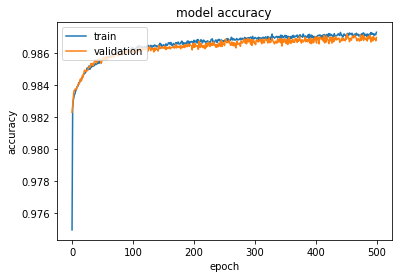

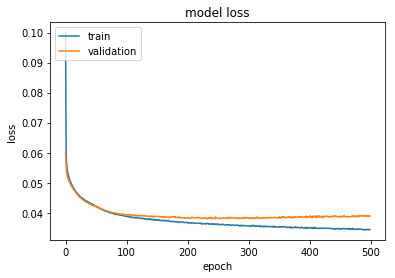

In [12]:


# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()